# **Import Library dan Dataset**

In [1]:
!pip install transformers

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/train.csv")
df.head()

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
0,Objective-Dependent Uncertainty Driven Retinal...,From diagnosing neovascular diseases to dete...,0,0,1
1,SMARTies: Sentiment Models for Arabic Target E...,We consider entity-level sentiment analysis ...,0,1,0
2,State-Aware Tracker for Real-Time Video Object...,In this work we address the task of semi-sup...,0,0,1
3,On the Performance of Optimized Dense Device-t...,We consider a D2D wireless network where $n$...,1,0,0
4,Design of Minimum Correlated Maximal Clique Se...,This paper proposes an algorithm to search a...,1,0,0


# **Preprocessing**

In [7]:
df.drop(columns=['title'], inplace=True)

In [8]:
# Load dataset
X = df['abstract']
y = df[['InformationTheory', 'ComputationalLinguistics', 'ComputerVision']]

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# **Modeling**

**Random Forest**

In [11]:
# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

NameError: name 'classification_report' is not defined

**Logistic Regression**

In [21]:
# Wrap Logistic Regression with MultiOutputClassifier
clf = MultiOutputClassifier(LogisticRegression(max_iter=1000))

# Train the model
clf.fit(X_train, y_train)

# Predict
y_pred_lr = clf.predict(X_test)

# **Evaluation**

**Random Forest**

In [25]:
# Subset accuracy (semua label harus benar)
subset_accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Label-wise accuracy
label_accuracy_rf = {}
for i, col in enumerate(y_test.columns):
    label_accuracy_rf[col] = accuracy_score(y_test[col], y_pred_rf[:, i])

print("\nRandom Forest:")
print(f"Subset Accuracy: {subset_accuracy_rf:.2f}")
print("Label-wise Accuracy:", label_accuracy_rf)


Random Forest:
Subset Accuracy: 0.92
Label-wise Accuracy: {'InformationTheory': 0.97636, 'ComputationalLinguistics': 0.95196, 'ComputerVision': 0.94064}


In [32]:
# Evaluation
for i, col in enumerate(y.columns):
    print(f"Classification report for {col}:")
    print(classification_report(y_test[col], y_pred_rf[:, i]))

Classification report for InformationTheory:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18984
           1       0.97      0.93      0.95      6016

    accuracy                           0.98     25000
   macro avg       0.98      0.96      0.97     25000
weighted avg       0.98      0.98      0.98     25000

Classification report for ComputationalLinguistics:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     19062
           1       0.93      0.86      0.90      5938

    accuracy                           0.95     25000
   macro avg       0.94      0.92      0.93     25000
weighted avg       0.95      0.95      0.95     25000

Classification report for ComputerVision:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     11954
           1       0.94      0.95      0.94     13046

    accuracy                           0.94

**Logistic Regression**

In [24]:
# Subset accuracy (semua label harus benar)
subset_accuracy_lr = accuracy_score(y_test, y_pred_lr)

# Label-wise accuracy
label_accuracy_lr = {}
for i, col in enumerate(y_test.columns):
    label_accuracy_lr[col] = accuracy_score(y_test[col], y_pred_lr[:, i])

print("Logistic Regression:")
print(f"Subset Accuracy: {subset_accuracy_lr:.2f}")
print("Label-wise Accuracy:", label_accuracy_lr)

Logistic Regression:
Subset Accuracy: 0.93
Label-wise Accuracy: {'InformationTheory': 0.98236, 'ComputationalLinguistics': 0.96148, 'ComputerVision': 0.95012}


In [33]:
# Evaluation
for i, col in enumerate(y.columns):
    print(f"Classification report for {col}:")
    print(classification_report(y_test[col], y_pred_lr[:, i]))

Classification report for InformationTheory:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18984
           1       0.97      0.96      0.96      6016

    accuracy                           0.98     25000
   macro avg       0.98      0.97      0.98     25000
weighted avg       0.98      0.98      0.98     25000

Classification report for ComputationalLinguistics:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     19062
           1       0.94      0.90      0.92      5938

    accuracy                           0.96     25000
   macro avg       0.95      0.94      0.95     25000
weighted avg       0.96      0.96      0.96     25000

Classification report for ComputerVision:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     11954
           1       0.95      0.95      0.95     13046

    accuracy                           0.95

### **ROC Curve**

In [29]:
# Function to plot ROC Curve
def plot_roc_curve(y_test, y_pred_prob, model_name):
    plt.figure(figsize=(10, 6))

    for i, col in enumerate(y_test.columns):
        # Calculate ROC and AUC
        fpr, tpr, _ = roc_curve(y_test[col], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{col} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title(f'ROC Curve for {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

**Random Forest**

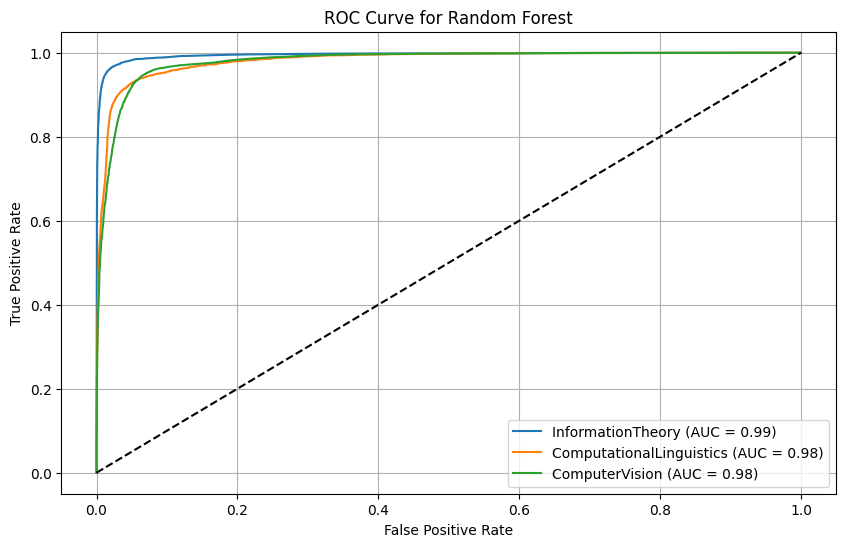

In [30]:
# Predict probabilities for each label
y_pred_prob_rf = rf.predict_proba(X_test)
y_pred_prob_rf = np.array([prob[:, 1] for prob in y_pred_prob_rf]).T  # Reshape to (n_samples, n_classes)

plot_roc_curve(y_test, y_pred_prob_rf, "Random Forest")

**Logistic Regression**

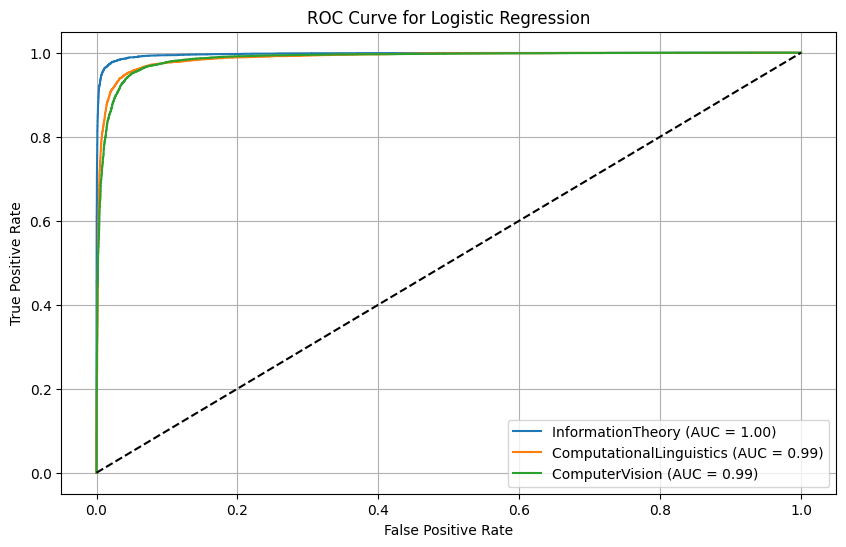

In [31]:
# Predict probabilities for each label
y_pred_prob_lr = clf.predict_proba(X_test)
y_pred_prob_lr = np.array([prob[:, 1] for prob in y_pred_prob_lr]).T  # Reshape to (n_samples, n_classes)

plot_roc_curve(y_test, y_pred_prob_lr, "Logistic Regression")